In [15]:
import sys 
import datetime

sys.path.insert(0, '../')

from constants import * 
import datasets
import loss_fns
import models
import util
import pdb

from matplotlib import pyplot as plt

In [16]:
def keep_track_doy_crop(DOY_counts, DOY_sums, DOY_sums_sqd, inputs, targets, source):
    # For each input example and corresponding target,
    if source == 's1':
        doy_band_idx = 3
    elif source == 's2':
        doy_band_idx = 11
    
    for ex_idx in range(inputs.shape[0]):
        # For each band,
        for band_idx in range(inputs.shape[2]):
            for time_idx in range(inputs.shape[1]):
                # Index pixels of desired crop
                for crop_idx in range(targets.shape[1]):
                    # Index into current pixels
                    cur_crop_vals = inputs[ex_idx, time_idx, band_idx, :, :]
                        
                    if source == 's2':
                        # Get pixels for current crop type class
                        yes_targets = targets[ex_idx, crop_idx, :, :] == 1
                        # Filter out cloudy images
                        not_cloudy = inputs[ex_idx, time_idx, 10, :, :] >= -0.3
                        # Get the AndFilter of these results
                        desired_idxs = yes_targets * not_cloudy
                            
                        cur_crop_vals = cur_crop_vals[desired_idxs == 1]
                    else:
                        cur_crop_vals = cur_crop_vals[targets[ex_idx, crop_idx, :, :] == 1]
                        
                    cur_doy = int(inputs[ex_idx, time_idx, doy_band_idx, 0, 0] * 177.5 + 177.5)
                        
                    # Put sum of pixels into correct band, doy element of DOY_sums
                    DOY_sums[band_idx, crop_idx, cur_doy] += np.sum(cur_crop_vals)

                    # Put sum of sqd pixels into correct band, doy element of DOY_sums_sqd
                    DOY_sums_sqd[band_idx, crop_idx, cur_doy] += np.sum(cur_crop_vals**2)
                        
                    # Put number of pixels into correct band, doy element of DOY_count
                    DOY_counts[band_idx, crop_idx, cur_doy] += len(cur_crop_vals)
                        
    return DOY_counts, DOY_sums, DOY_sums_sqd

In [17]:
def get_stats(model_name, args=None, dataloaders=None, num_bands=None):
    if num_bands == 4:
        source = 's1'
    elif num_bands == 12:
        source = 's2'
    
    if model_name in DL_MODELS:
        DOY_counts = None
        for i in range(args.epochs):
            for split in ['train', 'val', 'test']:
                dl = dataloaders[split]
                for inputs, targets, cloudmasks in dl:
                
                    if DOY_counts is None:
                        print('DOY counts is None')
                        DOY_sums = np.zeros((num_bands, targets.shape[1], 365))
                        DOY_sums_sqd = np.zeros_like(DOY_sums)
                        DOY_counts = np.zeros_like(DOY_sums)
                    
                    DOY_counts, DOY_sums, DOY_sums_sqd = keep_track_doy_crop(DOY_counts, DOY_sums, DOY_sums_sqd, inputs.numpy(), targets.numpy(), source)
                    
    return DOY_counts, DOY_sums, DOY_sums_sqd

In [33]:
train_parser = util.get_train_parser()
args = train_parser.parse_args(['--epochs', str(1),
                                '--model_name', 'fcn_crnn',
                                '--dataset', 'full', 
                                '--num_classes', str(4),
                                #'--country', 'tanzania',
                                #'--hdf5_filepath', '/home/roserustowicz/croptype_data_local/data/tanzania/data.hdf5',
                                #'--grid_dir', '/home/roserustowicz/croptype_data_local/data/tanzania',                                
                                '--country', 'southsudan',
                                '--hdf5_filepath', '/home/roserustowicz/croptype_data_local/data/southsudan/data.hdf5',
                                '--grid_dir', '/home/roserustowicz/croptype_data_local/data/southsudan',
                                #'--country', 'ghana',
                                #'--hdf5_filepath', '/home/roserustowicz/croptype_data_local/data/ghana/data.hdf5',
                                #'--grid_dir', '/home/roserustowicz/croptype_data_local/data/ghana',
                                '--batch_size', str(1),
                                '--hidden_dims', str(4),
                                '--crnn_num_layers', str(1),
                                '--use_s1', str(False),
                                '--use_s2', str(True),
                                '--sample_w_clouds', str(False),
                                '--include_clouds', str(True),
                                '--include_doy', str(True),
                                '--bidirectional', str(False), 
                                '--shuffle', str(False),
                                '--normalize', str(False),
                                '--apply_transforms', str(False),
                                '--least_cloudy', str(False),
                                '--all_samples', str(True)])   # if this is True, takes all samples and filters by cloudiness
    
# load in data generator
dataloaders = datasets.get_dataloaders(args.grid_dir, args.country, args.dataset, args)
    
if args.use_s1 == True and args.include_doy == True:
    num_bands = 4
elif args.use_s2 == True and args.include_doy == True and args.include_clouds == True:
    num_bands = 12
else:
    print("ERROR! Check input args for this script!")
            
DOY_counts, DOY_sums, DOY_sums_sqd = get_stats(args.model_name, args, dataloaders=dataloaders, num_bands=num_bands)
    
print('doy sums: ', DOY_sums.shape)
print('doy sums sqd: ', DOY_sums_sqd.shape)
print('doy count: ', DOY_counts.shape)

DOY counts is None
doy sums:  (12, 4, 365)
doy sums sqd:  (12, 4, 365)
doy count:  (12, 4, 365)


In [34]:
# Set 0 count means and stds to 0
means = DOY_sums / (DOY_counts)
means[DOY_counts == 0] = 0

stds = np.sqrt( (DOY_sums_sqd / (DOY_counts)) - (DOY_sums / (DOY_counts))**2 )
stds[DOY_counts == 0] = 0


/home/roserustowicz/anaconda3/envs/croptype/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/roserustowicz/anaconda3/envs/croptype/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/roserustowicz/anaconda3/envs/croptype/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/home/roserustowicz/anaconda3/envs/croptype/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/home/roserustowicz/anaconda3/envs/croptype/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


In [35]:
num_days_to_aggregate = 15

# Define kernel for convolution
#kernel = np.ones((3,))
#kernel /= np.sum(kernel)   

stats = {}
days = np.array(list(range(365)))

mean_stats = []
std_stats = []
doy_idxs = list(range(0, 365, num_days_to_aggregate))

for class_idx in range(means.shape[1]):
    for band_idx in range(means.shape[0]):
        tmp_class_means = means[band_idx, class_idx, :] # 365
        class_means = []
        for doy_idx in range(1, len(doy_idxs)):
            
            cur_means_doyrange = means[band_idx, class_idx, doy_idxs[doy_idx-1]:doy_idxs[doy_idx]] # 365
            cur_means_nonzero = cur_means_doyrange[cur_means_doyrange != 0]
            class_means.append(np.mean(cur_means_nonzero))
            
        stats[f'mean_c{class_idx}_b{band_idx}'] = class_means
        stats[f'days_c{class_idx}_b{band_idx}'] = doy_idxs[1:]      
           
        #stats[f'mean_c{class_idx}_b{band_idx}'] = tmp_class_means[tmp_class_means != 0]
        #stats[f'days_c{class_idx}_b{band_idx}'] = days[tmp_class_means != 0]
        #stats[f'stds_c{class_idx}_b{band_idx}'] = stds[band_idx, class_idx, :][tmp_class_means != 0]
        #stats[f'smooth_c{class_idx}_b{band_idx}'] = np.convolve(stats[f'mean_c{class_idx}_b{band_idx}'], 
        #                                                    kernel, mode='same')   
        #stats[f'interp_c{class_idx}_b{band_idx}'] = np.interp(list(range(365)), 
        #                                                  stats[f'days_c{class_idx}_b{band_idx}'],
        #                                                  stats[f'mean_c{class_idx}_b{band_idx}'])
        mean_stats.append(tmp_class_means[tmp_class_means != 0])
        std_stats.append(stds[band_idx, class_idx, :][tmp_class_means != 0])
        
print(len(mean_stats))   

48


/home/roserustowicz/anaconda3/envs/croptype/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/roserustowicz/anaconda3/envs/croptype/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


southsudan
(12, 4, 365)


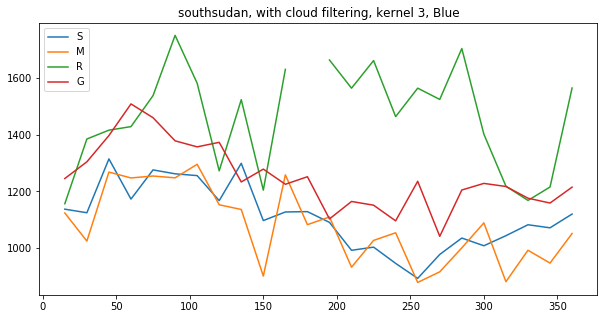

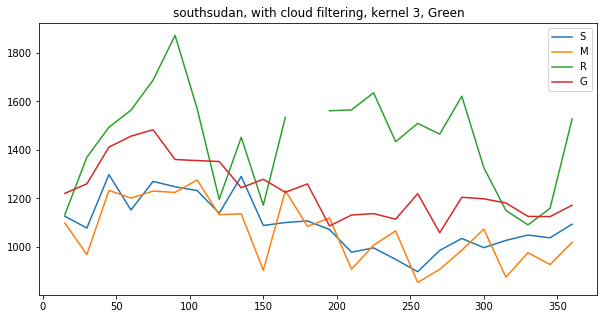

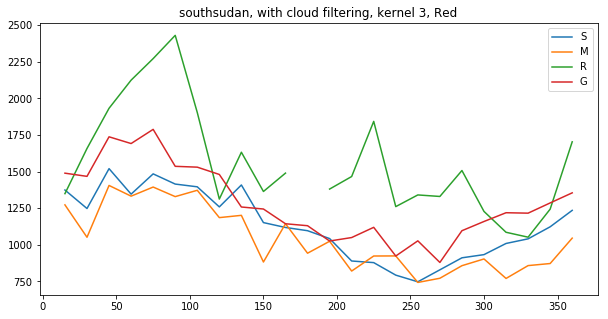

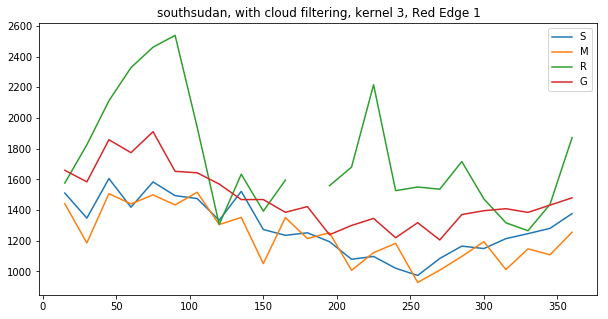

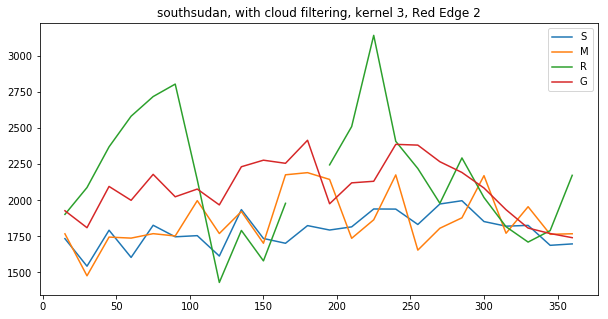

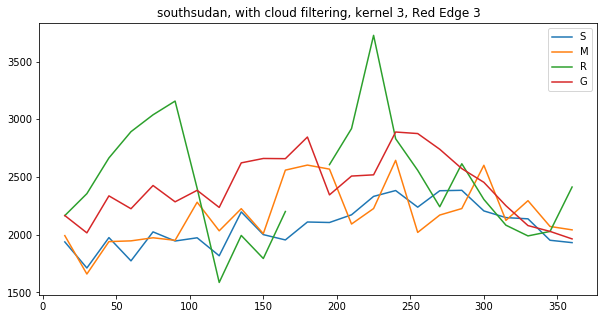

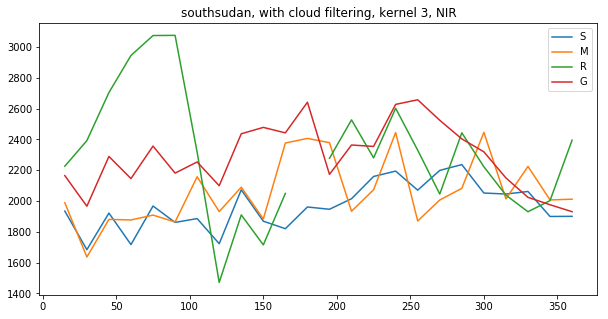

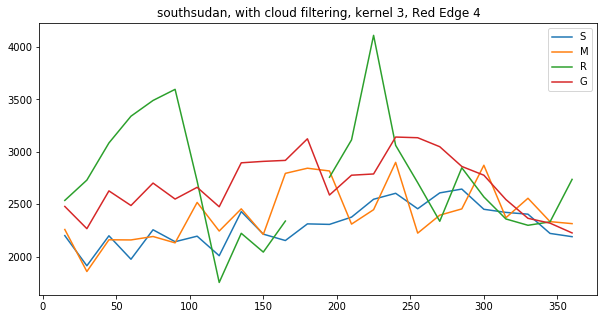

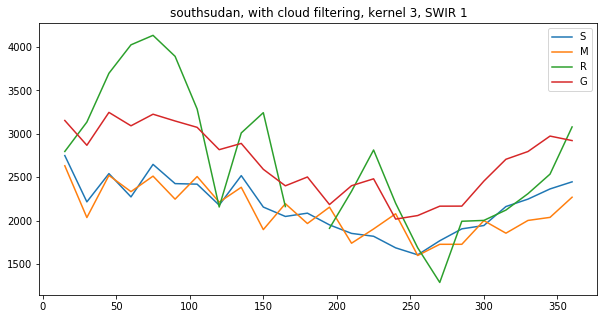

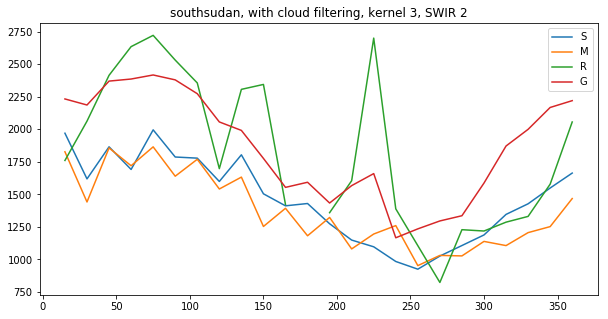

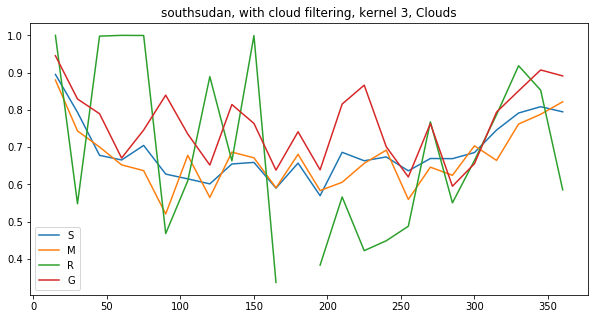

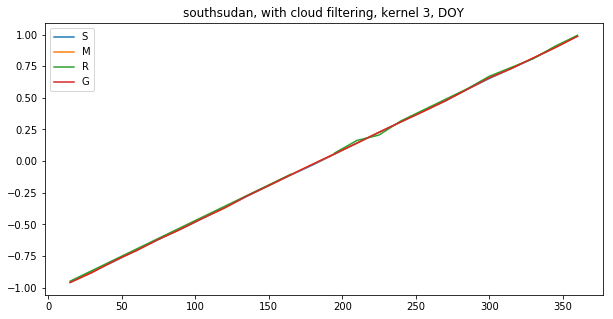

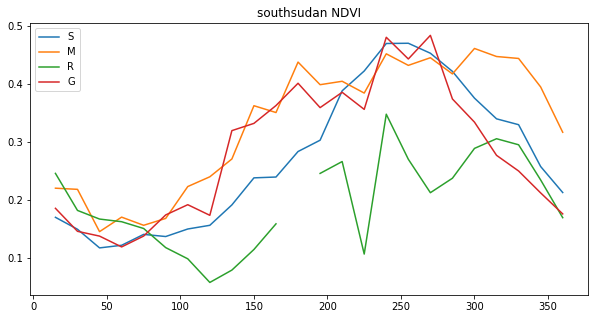

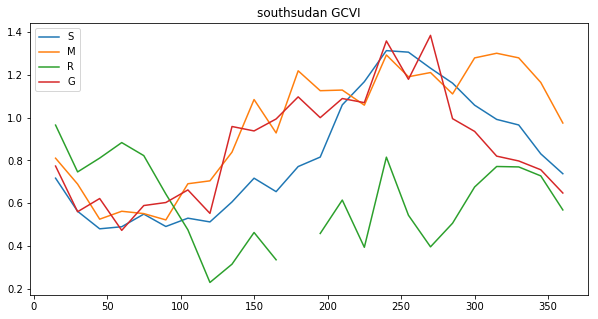

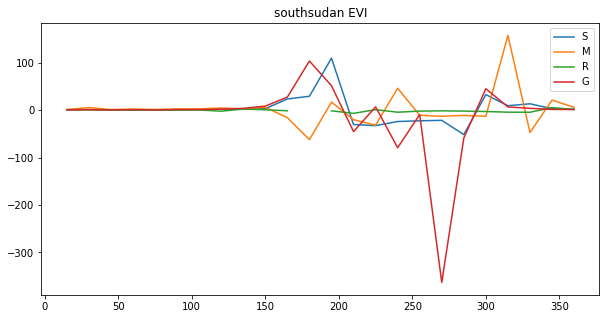

In [36]:
country = args.country

print(country)

if country == 'ghana':
    leg = 'GMRS' # groundnut, maize, rice, soy bean
elif country == 'southsudan':
    leg = 'SMRG' # sorghum, maize, rice, groundnut
elif country == 'tanzania':
    leg = 'MBSCW' # maize, mean, sunflower, chickpeas
    
print(means.shape)
s1_bands = {'0': 'VV', '1': 'VH', '2': 'VH/VV', '3': 'DOY'}
s2_bands = {'0': 'Blue', '1': 'Green', '2': 'Red', '3': 'Red Edge 1', '4': 'Red Edge 2', '5': 'Red Edge 3', 
            '6': 'NIR', '7': 'Red Edge 4', '8': 'SWIR 1', '9': 'SWIR 2', '10': 'Clouds', '11': 'DOY'}

if args.use_s1 == True:
    band_dict = s1_bands
elif args.use_s2 == True:
    band_dict = s2_bands

for band_idx in range(means.shape[0]):
    plt.figure(figsize=(10, 5));
    plt.title(country + ', with cloud filtering, kernel 3, ' + band_dict[str(band_idx)])
    for class_idx in range(means.shape[1]):
        #plt.figure(figsize=(10, 5));
        #plt.title(country + ' ' + band_dict[str(band_idx)] + ' class ' + str(class_idx))    #plt.plot(stats[f'days_c{class_idx}_b{band_idx}'], stats[f'stds_c{class_idx}_b{band_idx}'])
        plt.plot(stats[f'days_c{class_idx}_b{band_idx}'], stats[f'mean_c{class_idx}_b{band_idx}'])
        #plt.plot(stats[f'days_c{class_idx}_b{band_idx}'], stats[f'smooth_c{class_idx}_b{band_idx}'])
        #plt.plot(list(range(365)), stats[f'interp_c{class_idx}_b{band_idx}'])
        plt.legend(leg)
        
# Plot other indices
if args.use_s2 == True:
    # NDVI = (NIR - R) / (NIR + R)
    plt.figure(figsize=(10,5))
    plt.title(country + ' NDVI')
    for class_idx in range(means.shape[1]):
        #ndvi = (stats[f'smooth_c{class_idx}_b6'] - stats[f'smooth_c{class_idx}_b2']) / (stats[f'smooth_c{class_idx}_b6'] + stats[f'smooth_c{class_idx}_b2']) 
        ndvi = (np.array(stats[f'mean_c{class_idx}_b6']) - np.array(stats[f'mean_c{class_idx}_b2'])) / (np.array(stats[f'mean_c{class_idx}_b6']) + np.array(stats[f'mean_c{class_idx}_b2'])) 
        plt.plot(stats[f'days_c{class_idx}_b6'], ndvi)
        plt.legend(leg)
    
    # GCVI = ( NIR / G ) - 1
    plt.figure(figsize=(10,5))
    plt.title(country + ' GCVI')
    for class_idx in range(means.shape[1]):
        #gcvi = stats[f'smooth_c{class_idx}_b6'] / stats[f'smooth_c{class_idx}_b1'] - 1
        gcvi = np.array(stats[f'mean_c{class_idx}_b6']) / np.array(stats[f'mean_c{class_idx}_b1']) - 1
        plt.plot(stats[f'days_c{class_idx}_b6'], gcvi)
        plt.legend(leg)

    # EVI = 2.5 (NIR - R) / (NIR + 6 R - 7.5 B + 1)
    plt.figure(figsize=(10,5))
    plt.title(country + ' EVI')
    for class_idx in range(means.shape[1]):
        evi = 2.5 * (np.array(stats[f'mean_c{class_idx}_b6']) - np.array(stats[f'mean_c{class_idx}_b2'])) / (np.array(stats[f'mean_c{class_idx}_b6']) + 6*np.array(stats[f'mean_c{class_idx}_b2']) - 7.5 * np.array(stats[f'mean_c{class_idx}_b0']) + 1)
        plt.plot(stats[f'days_c{class_idx}_b6'], evi)
        plt.legend(leg)